# Time Series Modeling

In this lecture, we'll do some **basic** work with time series modeling. Time series are surprisingly complicated objects to work with and model, and many people spend their careers considering statistical questions related to effective modeling of timeseries. In this set of lecture notes, we won't be able to go into too much detail, but we will highlight some of the key questions and approaches to addressing them. 

## Note

*I had originally intended to approach time series modeling from a deep learning perspective, using TensorFlow. This is possible; see [here](https://www.tensorflow.org/tutorials/structured_data/time_series) for an example. The general idea is actually pretty similar to what we used for text generation. However, a quick check indicated that contemporary best practice is still to use models developed in econometrics and statistics, as these tend to be more accurate and more interpretable.*

*Parts of these lecture notes are based on [this tutorial](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b). For an overview of the functionality available in the statsmodels package for timeseries, take a look [here](https://www.statsmodels.org/stable/tsa.html). Here is a [nice overview](https://people.duke.edu/~rnau/411arim.htm) of basic ARIMA models, which can help give some interpretation for the meaning of the `order` parameter that we use below.* 

In [4]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid')
import statsmodels.api as sm

## Data: NOAA Climate

For this lecture, we're actually going to go back to the NOAA climate data that we used early in the quarter. Using the database that we constructed in Week 2, I'm going to grab data for Amundsen-Scott weather station, which is in the deep Antarctic. 

In [5]:
with sqlite3.connect("../sql/temps.db") as conn:

    cmd = \
    """
    SELECT S.name, T.year, T.month, T.temp
    FROM temperatures T
    LEFT JOIN stations S ON T.id = S.id
    WHERE S.NAME == "AMUNDSEN_SCOTT" AND T.year > 2000
    """

    df = pd.read_sql_query(cmd, conn)

## Quick Data Prep

There's a bit of data preparation needed before we can do formal time series modeling. In particular, we need to make a **Date** column, and set it as the index for the timeseries that we care about. 

In [6]:
df["Date"] = df["Year"].astype(str) + "-" + df["Month"].astype(str)
df["Date"] = pd.to_datetime(df["Date"])
df.head()

,NAME,Year,Month,Temp,Date
0,AMUNDSEN_SCOTT,2001,1,-29.7,2001-01-01
1,AMUNDSEN_SCOTT,2001,2,-39.0,2001-02-01
2,AMUNDSEN_SCOTT,2001,3,-54.8,2001-03-01
3,AMUNDSEN_SCOTT,2001,4,-60.2,2001-04-01
4,AMUNDSEN_SCOTT,2001,5,-58.3,2001-05-01


The next thing we need to do is set the Date as the index for our dataframe. 

In [7]:
df.index = pd.DatetimeIndex(df["Date"], freq = "MS")

Finally, we are going to want to make predictions and test them, which means that we still perform a train/test split. I'm going to take the most recent 4 years as test data. 

In [8]:
recency = -48
y_train = df.iloc[:recency]["Temp"]
y_test  = df.iloc[recency:]["Temp"]
y_train.shape, y_test.shape

((193,), (48,))

Finally, let's take a look at our training data. 

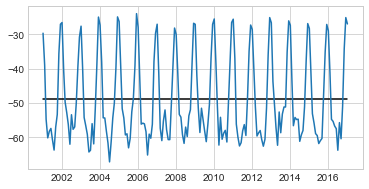

In [9]:
m = y_train.mean()
time = y_train.index
fig, ax = plt.subplots(1, figsize = (6, 3))
ax.plot(time, np.ones(len(time))*m, label = "reference", color = "black")
ax.plot(y_train, label = "temp")

Notice that there is considerable seasonal variation, on the order of 30 degrees Celsius, within each year. This can make it difficult to see trends. For example, would you say that the overall trend in this image is upward, downard, or neutral? It's very difficult to say! Let's now introduce an exploratory tool that can help us think about this kind of question. 

## Time series Decomposition

Time series decomposition is  technique for exploratory data analysis that allows you to separate a time series into separate components, like this: 

$$\text{data} = \text{trend} + \text{seasonal} +  \text{noise}$$

Technically speaking, the above corresponds to an *additive* model. We can also use a multiplicative model: 

$$\text{data} = \text{trend} \times \text{seasonal} \times  \text{noise}$$

The choice of which model to use for decomposition can be a tricky one, but additive models are usually a sound place to start. 

In [10]:
# specifying period not necessary because we have the frequency defined
# so this would also work: 
# decomposition = sm.tsa.seasonal_decompose(y, model='additive') 
decomposition = sm.tsa.seasonal_decompose(y_train, model='additive', period = 12, ) 

The object returned by the decomposition has a convenient `plot()` method. 

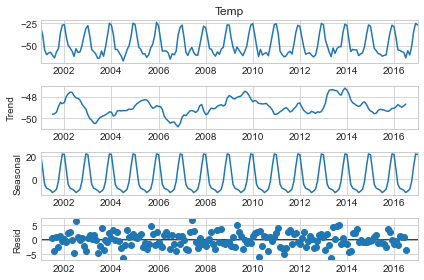

In [11]:
fig = decomposition.plot()

Visually, you can "add up" the bottom three rows to obtain the top three row. In a bit more detail: 

1. The `trend` component is the model's best estimate of the overall direction of the data up or down. 
2. The `seasonal` component is the model's best estimate of seasonal variation. It's constrained to be periodic (in this case, with period 12). 
3. The `resid`ual is whatever part of the data is left over. Large residuals, or residuals with nonstationary distributions (distributions that change over time) suggest that the model we used for the decomposition was not very good. 

There are many choices of model that can be used for timeseries decomposition. The default in the `statsmodels` package is based on moving averages and is relatively naive. Much more sophisticated models are typically used in practice. 

Now that we've performed our decomposition, we're equipped to re-examine our question from earlier about the trend in temperatures at Amundsen-Scott station. 

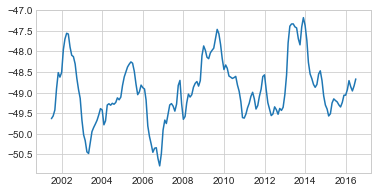

In [12]:
trend = decomposition.trend
time = trend.index
m = decomposition.trend.mean()
fig, ax = plt.subplots(1, figsize = (6, 3))
# ax.plot(time, np.ones(len(time))*m, label = "reference", color = "grey")
ax.plot(trend, label = "trend")

The trendline still displays considerable fluctuation. It looks like there may be some upward trend, but more data or a more sophisticated decomposition method would be required in order to say anything conclusive here. 

## Time Series Forecasting

Decomposition is a useful tool that can help us spot trends in data. However, we often want to do better than trendspotting. For this, we should select and fit statistical models. The problem of choosing exactly which model to use is quite subtle, and the statistical theory of this problem can occupy entire courses and even research careers. If you're interested in learning the theory of time series analysis, Statistics 170 at UCLA appears to be the way to go. 

When we take a machine-learning approach to this problem, we can, to an extent, circumvent the theoretical questions by evaluating models on validation data. That's what we'll do today. However, this approach can really only go so far -- sound footing in both the theory of time series and the domain you're studying are necessary for best results here. 

Let's do an example using a SARIMAX model, which stands for "Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors." These are fairly general and flexible models for seasonal data. When fitting models such as these, it's necessary to specify one or more `order` parameters used to determine the structure of the model. 

In [13]:
order = (0, 1, 0)

This specification means that we are going to use a first-order auto-regressive model with 0th-order differences and a 0th order moving average. 

The SARIMAX model also uses a separate *seasonal* mini-model, which requires its own parameters. The `12` here refers to the 12 months of the year. 

In [14]:
seasonal_order = (0, 1, 1, 12)

In [15]:
model = sm.tsa.SARIMAX(y_train, order = order, seasonal_order = seasonal_order)

In [16]:
fit = model.fit()

In [17]:
print(fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                 Temp   No. Observations:                  193
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -498.915
Date:                              Fri, 14 May 2021   AIC                           1001.830
Time:                                      09:20:13   BIC                           1008.216
Sample:                                  01-01-2001   HQIC                          1004.419
                                       - 01-01-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9931      1.318     -0.754      0.451      -3.576       1.590
sigma2        12.52

## Forecasting

By default, the `get_prediction()` method of the `fit` object will produce the model's "prediction" on training data. 

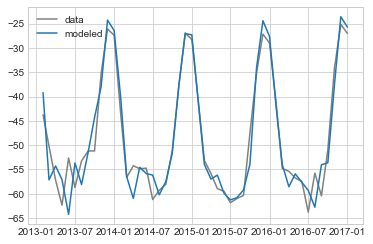

In [18]:
train_preds = fit.get_prediction().predicted_mean

recency = -48

plt.plot(y_train[recency:], color = "grey", label = "data")
plt.plot(train_preds[recency:], zorder = 10, label = "modeled")
plt.legend()

To get the predictions on test data, we can pass explicit `start` and `end` parameters. 

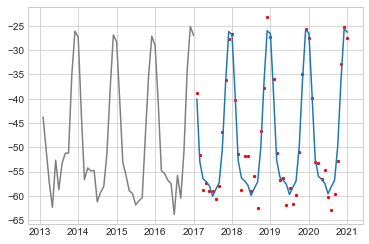

In [19]:
test_preds = fit.get_prediction(start = y_test.index.values[0], 
                                 end  = y_test.index.values[-1])

test_preds = test_preds.predicted_mean

recency = -48

plt.plot(y_train[recency:], color = "grey", label = "data")
plt.scatter(y_test.index.values, y_test, color = "red", label = "test data", s = 5)
plt.plot(test_preds, zorder = 10, label = "modeled")
# plt.legend()

Looks pretty reasonable overall! 

One important item here is missing: an expression of our uncertainty. Because these are statistical models, they have error bars. Communicating the error bars appropriately is a fundamental part of responsible forecasting. Here's a way to plot them. 

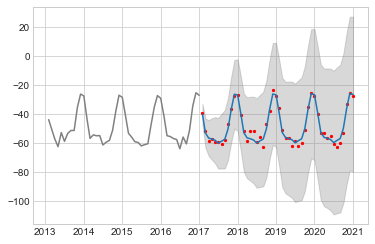

In [20]:
test_preds = fit.get_prediction(start = y_test.index.values[0], 
                                 end  = y_test.index.values[-1])

test_ci = test_preds.conf_int()

test_preds = test_preds.predicted_mean

recency = -48

plt.plot(y_train[recency:], color = "grey", label = "data")

plt.fill_between(test_ci.index, test_ci.iloc[:,0], test_ci.iloc[:,1], color = "gray", alpha = 0.3)

plt.scatter(y_test.index.values, y_test, color = "red", label = "test data", s = 5)
plt.plot(test_preds, zorder = 10, label = "modeled")
# plt.legend()

As we'd expect, although the model doesn't perfectly fit every individual piece of data, the data falls within the error bars the vast majority of the time. 

Finally, we can also use our model for long-term predictions: 

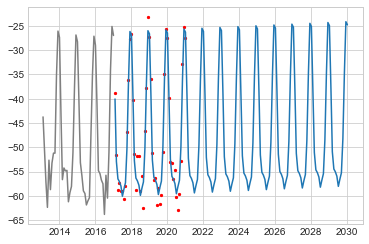

In [21]:
test_preds = fit.get_prediction(start = y_test.index.values[0], 
                                 end  = pd.to_datetime('2030-01-01'))

test_ci = test_preds.conf_int()

test_preds = test_preds.predicted_mean

recency = -48

plt.plot(y_train[recency:], color = "grey", label = "data")

plt.scatter(y_test.index.values, y_test, color = "red", label = "test data", s = 5)
plt.plot(test_preds, zorder = 10, label = "modeled")

This model appears to predict a considerable increase in temperature, on the order of 1-2 ℃ over the next 10 years. 

## Model Selection

In the last example, we used  the `order` and `seasonal_order` parameters above to specify the model structure. We didn't really talk about what these parameters mean, and going into detail would take us well beyond the scope of this course. However, we do have to face the problem of how to *choose* these parameters. For this, a convenient approach is to define a predictive loss function and choose the combination of parameters that minimizes it. This is not the statistically principled way to do things -- it's very much in the machine learning spirit. 

Here's an example in which we'll compare multiple possibilities for the `order` parameter by searching across all combinations within a specified range. In machine learning, this strategy is called "*grid search*." It's really only practical when we have a small number of combinations and when our model is fairly quick to train. 

There are multiple choices for the loss function. A common one to use is the AIC, which is a measure that trades off model complexity and accuracy. 

In [22]:
fit.aic

1001.830094680986

The AIC is an ok thing to compute when we don't have access to test data, but...we do! So, instead of computing the AIC, we'll instead compute the mean-square prediction error on the test set. 

In [23]:
def test_MSE(fit, y_test):
    
    test_preds = fit.get_prediction(start = y_test.index.values[0], 
                                    end  = y_test.index.values[-1])
    test_preds = test_preds.predicted_mean
    
    return ((y_test - test_preds)**2).mean()

In [24]:
from itertools import product
a = range(0, 2)

best_order = (0, 0, 0)
best_MSE   = np.inf
for order in product(a, a, a):
    model = sm.tsa.SARIMAX(y_train, order = order, seasonal_order = seasonal_order)
    fit = model.fit()
    MSE = test_MSE(fit, y_test)
    if MSE < best_MSE:
        print("Found MSE " + str(round(MSE, 2)) + " with order " + str(order))
        best_MSE = MSE
        best_order = order
        best_model = model    

Found MSE 6.71 with order (0, 0, 0)
Found MSE 6.71 with order (0, 0, 1)
Found MSE 6.01 with order (0, 1, 0)


By sheer coincidence, the best order is the same one that I used to construct the original model above. One could also use this strategy to choose the `seasonal_order` parameters. 

## Reminder

Time series forecasting is a challenging art that requires both statistical know-how and knowledge of the data source in order to do responsibly. The approach here, using validation on unseen test data to perform model selection, is a reasonable way to get started. If you are seriously interested in time series forecasting, however, there's no substitute for a course (like Stat 170) and lots of practice. 